# Project : Speed dating

## 1. First look at the data 

Description of the variables is available [here](./Speed%20Dating%20Data%20Key.pdf)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pio.renderers.default = "iframe_connected"

df = pd.read_csv('Speed Dating Data.csv', encoding='ISO-8859-1')
print(df.shape)
df.head()

(8378, 195)


,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [2]:
pd.options.display.precision = 2
pd.options.display.max_columns = 200
pd.options.display.max_colwidth = 15
display(df)

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,1,11.0,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,2,12.0,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,3,13.0,1,0.16,1,22.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0,21.0,Law,1.0,NaN,NaN,NaN,4.0,2.0,4.0,Chicago,"60,521","69,487.00",2.0,7.0,1.0,lawyer,NaN,9.0,2.0,8.0,9.0,1.0,1.0,5.0,1.0,5.0,6.0,9.0,1.0,10.0,10.0,9.0,8.0,1.0,3.0,2.0,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,35.0,20.0,15.0,20.0,5.0,5.0,6.0,8.0,8.0,8.0,7.0,NaN,NaN,NaN,NaN,NaN,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,19.44,16.67,13.89,22.22,11.11,16.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,8.0,7.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,15.0,20.0,20.0,15.0,15.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,4,14.0,1,0.61,0,23.0,2.0,30.0,5.0,15.0,40.0,5.0,5.0,1,7.0,8.0,9.0,8.0,9

In [3]:
df.describe(include = 'all')

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
count,8378.00,8377.00,8378.0,8378.00,8378.00,8378.00,8378.00,8378.00,6532.00,8378.00,8378.00,8368.00,8378.00,8220.00,8378.00,8274.00,8305.00,8289.00,8289.00,8289.00,8280.00,8271.00,8249.00,8378.00,8166.00,8091.00,8072.00,8018.00,7656.00,7302.00,8128.00,8060.00,7993.00,8283.00,8315,8296.00,4914,3133,3583,8315.00,8299.00,8299.00,8299,7314,4279,8299.00,8281.00,8299.00,8289,8240.00,8299.00,8299.00,8299.00,8299.00,8299.00,8299.00,8299.00,8299.00,8299.00,8299.00,8299.00,8299.00,8299.00,8299.00,8299.00,8299.00,8299.00,8277.00,1800.00,8299.00,8299.00,8299.00,8289.00,8279.00,8257.00,6489.00,6489.00,6489.00,6489.00,6489.00,6467.00,8299.00,8299.00,8299.00,8299.00,8289.00,8289.00,8273.00,8273.00,8273.00,8273.00,8273.00,4906.00,4906.00,4906.00,4906.00,4906.00,8378.00,8176.00,8101.00,8082.00,8028.00,7666.00,7311.00,8138.00,8069.00,8003.00,7205.00,4096.00,4096.00,4096.00,4096.00,4096.00,4096.00,4000.00,4000.00,4000.00,4000.00,4000.00,7463.00,7463.00,7433.00,1984.00,1955.00,1984.00,1984.00,1955.00,1974.00,7445.00,7463.00,7463.00,7463.00,7463.00,7463.00,5775.00,5775.00,5775.00,5775.00,5775.00,5775.00,5775.00,5775.00,5775.00,5775.00,5775.00,5775.00,7463.00,7463.00,7463.00,7463.00,7463.00,4377.00,4377.00,4377.00,4377.00,4377.00,3974.00,3974.00,3974.00,1496.00,668.00,3974.00,3974.00,3974.00,3974.00,3974.0,3974.00,2016.00,2016.00,2016.00,2016.00,2016.00,2016.00,2959.00,2959.00,2959.00,2959.00,2959.00,2959.00,2959.00,2959.00,2959.00,2959.00,2959.00,2016.00,3974.00,3974.00,3974.00,3974.00,3974.00,2016.00,2016.00,2016.00,2016.00,2016.00
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,259,NaN,241,68,115,NaN,NaN,NaN,269,409,261,NaN,NaN,NaN,367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Business,NaN,UC Berkeley,"1,400.00","26,908.00",NaN,NaN,NaN,New York,0,"55,080.00",NaN,N

In [4]:
total_values_count = df.shape[0]*df.shape[1]
missing_values_count = df.isnull().values.sum()
print(f"On a total of {total_values_count} values in the dataset, there are {missing_values_count} missing values, which represent {round(missing_values_count/total_values_count*100)}%")

On a total of 1633710 values in the dataset, there are 432016 missing values, which represent 26%


-> We notice already that the dataset has **a lot of missing values**, let's analyse it a little more. 

## 2. Missing values : What are the participants so shy (or lazy) about ?

### 2.1. Overview

In [5]:
def get_missing_values_percentage(dataframe):
    # Input : dataframe (n rows, m columns)
    # Output : a series (m values) whose indexes are the input dataframe column names 
    #          and the values are the percentage of missing values found in the column,
    #          rounded to 2 decimal places.
    return dataframe.isnull().sum().apply(lambda x : round(x/dataframe.shape[0]*100, 2)) 

In [6]:
#Looking for the percentage of NaN values in each column
missing_values_series = get_missing_values_percentage(df)
missing_values_series

iid          0.00
id           0.01
gender       0.00
idg          0.00
condtn       0.00
            ...  
attr5_3     75.94
sinc5_3     75.94
intel5_3    75.94
fun5_3      75.94
amb5_3      75.94
Length: 195, dtype: float64

In [7]:
# Defining a function to display a long series as a horizontal DataFrame
def row_display(series): #Displays a pandas series horizontally as a 1-row-dataframe
    display_dataframe = pd.DataFrame(columns = series.index)
    display_dataframe.loc[0] = list(series.values)
    return display_dataframe

In [8]:
missing_values_row_df = row_display(missing_values_series)
print(missing_values_row_df.shape)
display(missing_values_row_df)

(1, 195)


,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o,age,field,field_cd,undergra,mn_sat,tuition,race,imprace,imprelig,from,zipcode,income,goal,date,go_out,career,career_c,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,exphappy,expnum,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,attr4_1,sinc4_1,intel4_1,fun4_1,amb4_1,shar4_1,attr2_1,sinc2_1,intel2_1,fun2_1,amb2_1,shar2_1,attr3_1,sinc3_1,fun3_1,intel3_1,amb3_1,attr5_1,sinc5_1,intel5_1,fun5_1,amb5_1,dec,attr,sinc,intel,fun,amb,shar,like,prob,met,match_es,attr1_s,sinc1_s,intel1_s,fun1_s,amb1_s,shar1_s,attr3_s,sinc3_s,intel3_s,fun3_s,amb3_s,satis_2,length,numdat_2,attr7_2,sinc7_2,intel7_2,fun7_2,amb7_2,shar7_2,attr1_2,sinc1_2,intel1_2,fun1_2,amb1_2,shar1_2,attr4_2,sinc4_2,intel4_2,fun4_2,amb4_2,shar4_2,attr2_2,sinc2_2,intel2_2,fun2_2,amb2_2,shar2_2,attr3_2,sinc3_2,intel3_2,fun3_2,amb3_2,attr5_2,sinc5_2,intel5_2,fun5_2,amb5_2,you_call,them_cal,date_3,numdat_3,num_in_3,attr1_3,sinc1_3,intel1_3,fun1_3,amb1_3,shar1_3,attr7_3,sinc7_3,intel7_3,fun7_3,amb7_3,shar7_3,attr4_3,sinc4_3,intel4_3,fun4_3,amb4_3,shar4_3,attr2_3,sinc2_3,intel2_3,fun2_3,amb2_3,shar2_3,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,22.03,0.0,0.0,0.12,0.0,1.89,0.0,1.24,0.87,1.06,1.06,1.06,1.17,1.28,1.54,0.0,2.53,3.43,3.65,4.3,8.62,12.84,2.98,3.8,4.6,1.13,0.75,0.98,41.35,62.6,57.23,0.75,0.94,0.94,0.94,12.7,48.93,0.94,1.16,0.94,1.06,1.65,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,0.94,1.21,78.52,0.94,0.94,0.94,1.06,1.18,1.44,22.55,22.55,22.55,22.55,22.55,22.81,0.94,0.94,0.94,0.94,1.06,1.06,1.25,1.25,1.25,1.25,1.25,41.44,41.44,41.44,41.44,41.44,0.0,2.41,3.31,3.53,4.18,8.5,12.74,2.86,3.69,4.48,14.0,51.11,51.11,51.11,51.11,51.11,51.11,52.26,52.26,52.26,52.26,52.26,10.92,10.92,11.28,76.32,76.67,76.32,76.32,76.67,76.44,11.14,10.92,10.92,10.92,10.92,10.92,31.07,31.07,31.07,31.07,31.07,31.07,31.07,31.07,31.07,31.07,31.07,31.07,10.92,10.92,10.92,10.92,10.92,47.76,47.76,47.76,47.76,47.76,52.57,52.57,52.57,82.14,92.03,52.57,52.57,52.57,52.57,52.57,52.57,75.94,75.94,75.94,75.94,75.94,75.94,64.68,64.68,64.68,64.68,64.68,64.68,64.68,64.68,64.68,64.68,64.68,75.94,52.57,52.57,52.57,52.57,52.57,75.94,75.94,75.94,75.94,75.94


In [9]:
missing_values_fig = go.Figure(
    data = go.Bar(x = missing_values_series.index, y = missing_values_series.values),
    layout = go.Layout(
        title = go.layout.Title(text = "Missing values percentage in the dataset", x = 0.5),
        xaxis = go.layout.XAxis(title = 'data',  tickangle = -90, rangeslider = go.layout.xaxis.Rangeslider(visible = True)),
        yaxis = go.layout.YAxis(title = '%', range = [0, 100])
    )
)

missing_values_fig.add_hline(y = 50, line_color = 'black', 
                              line_dash = 'dash', 
                              annotation_text = '50%', 
                              annotation_xanchor = 'left', 
                              annotation_x = 1.01, 
                              annotation_font_size = 14) #the last arguments are kwargs from the add_shape arguments and layout.Annotation properties  

missing_values_fig.show()

-> We observe that the last colums (from 'you_call' to the end of the dataset) contain a majority of NaN values.   
These columns correspond to the __answers to the last followup survey__ (3-4 weeks after they had been sent their matches)

It also seems like **the more we move forward in time from the experiment, the more missing values we have.**   
Before all, let's distinguish the data described in the document before the survey data (e.g. all first datas in the data key document til 'age' excluded) from the rest, as it seems to be global data, not chronologically defined before the survey, and probably filled out by the organizers and not the students participating.  

### 2.2. Non-survey data

In [10]:
df_non_survey = df.loc[:,'iid':'met_o']
df_non_survey

,iid,id,gender,idg,condtn,wave,round,position,positin1,order,partner,pid,match,int_corr,samerace,age_o,race_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,attr_o,sinc_o,intel_o,fun_o,amb_o,shar_o,like_o,prob_o,met_o
0,1,1.0,0,1,1,1,10,7,NaN,4,1,11.0,0,0.14,0,27.0,2.0,35.0,20.0,20.0,20.0,0.0,5.0,0,6.0,8.0,8.0,8.0,8.0,6.0,7.0,4.0,2.0
1,1,1.0,0,1,1,1,10,7,NaN,3,2,12.0,0,0.54,0,22.0,2.0,60.0,0.0,0.0,40.0,0.0,0.0,0,7.0,8.0,10.0,7.0,7.0,5.0,8.0,4.0,2.0
2,1,1.0,0,1,1,1,10,7,NaN,10,3,13.0,1,0.16,1,22.0,4.0,19.0,18.0,19.0,18.0,14.0,12.0,1,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,1.0
3,1,1.0,0,1,1,1,10,7,NaN,5,4,14.0,1,0.61,0,23.0,2.0,30.0,5.0,15.0,40.0,5.0,5.0,1,7.0,8.0,9.0,8.0,9.0,8.0,7.0,7.0,2.0
4,1,1.0,0,1,1,1,10,7,NaN,7,5,15.0,1,0.21,0,24.0,3.0,30.0,10.0,20.0,10.0,10.0,20.0,1,8.0,7.0,9.0,6.0,9.0,7.0,8.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,552,22.0,1,44,2,21,22,14,10.0,5,18,526.0,0,0.64,0,26.0,3.0,10.0,10.0,30.0,20.0,10.0,15.0,1,10.0,5.0,3.0,2.0,6.0,5.0,6.0,1.0,NaN
8374,552,22.0,1,44,2,21,22,13,10.0,4,19,527.0,0,0.71,0,24.0,6.0,50.0,20.0,10.0,5.0,10.0,5.0,0,6.0,3.0,7.0,3.0,7.0,2.0,2.0,2.0,2.0
8375,552,22.0,1,44,2,21,22,19,10.0,10,20,528.0,0,-0.46,0,29.0,3.0,40.0,10.0,30.0,10.0,10.0,NaN,0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0
8376,552,22.0,1,44,2,21,22,3,10.0,16,21,529.0,0,0.62,0,22.0,4.0,10.0,25.0,25.0,10.0,10.0,20.0,1,5.0,7.0,5.0,5.0,3.0,6.0,6.0,4.0,2.0


In [11]:
missing_values_series_non_survey = get_missing_values_percentage(df_non_survey)

missing_values_fig_non_survey = go.Figure(
    data = go.Bar(x = missing_values_series_non_survey.index, y = missing_values_series_non_survey.values),
    layout = go.Layout(
        title = go.layout.Title(text = "Missing values percentage in the non-survey data ", x = 0.5),
        xaxis = go.layout.XAxis(title = 'data',  tickangle = -90),
        yaxis = go.layout.YAxis(title = '%', range = [0, 100])
    )
)

missing_values_fig_non_survey.add_hline(y = 50, line_color = 'black', 
                              line_dash = 'dash', 
                              annotation_text = '50%', 
                              annotation_xanchor = 'left', 
                              annotation_x = 1.01, 
                              annotation_font_size = 14) #the last arguments are kwargs from the add_shape arguments and layout.Annotation properties  

missing_values_fig_non_survey.show()

**-> all the missing values percentages for the global, non-survey data are considered negligible**, except maybe for 'positin1' (station number where started)  

### 2.3. Survey data

#### 2.3.1. Missing values quantity evolution over time

Now let's split the survey data in different chronologically ordered categories, and show the mean percentage of missing values for each step : 
1. Registration to the event (columns `iid` to `amb5_1` included)
2. During the event (columns `dec` to `amb3_s` included)
3. 1-day-after follow-up - 'mandatory' survey (columns `satis_2` to `amb5_2` included)
4. 3/4-weeks-after matches follow-up - last survey (all last columns since `you_call`)

In [12]:
df_reg = df.loc[:,'age':'amb5_1']
df_event = df.loc[:,'dec':'amb3_s']
df_after_1d = df.loc[:,'satis_2':'amb5_2']
df_after_3w = df.loc[:,'you_call':]
df_list = [df_reg, df_event, df_after_1d, df_after_3w]
time_labels = ['Before the event\n(registration)', 'During the event', 'Follow-up survey\n1 day after the event', 'Follow-up survey\n3-4 weeks after the event']

In [13]:
# Storing the missing values series (each corresponding to a time period) into a list for plotting in different graphs
# and creating a Series (missing_values_summary) giving for each period of time its mean of missing values percentage
missing_values_series_list = []
missing_values_summary = []
for i, df_part in enumerate(df_list):
    missing_values_series_list.append(get_missing_values_percentage(df_part))
    missing_values_mean_percentage = missing_values_series_list[i].mean()
    missing_values_summary.append(missing_values_mean_percentage)
missing_values_summary = pd.Series(missing_values_summary, index = time_labels)

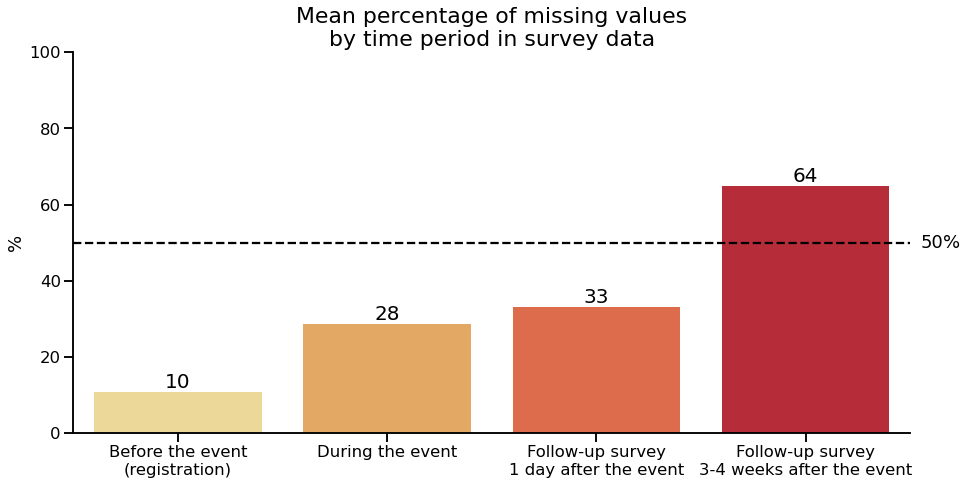

In [14]:
sns.set_context("talk") # Setting a default scale for the axis and labels
plt.figure(figsize = (15,7))
plt.title("Mean percentage of missing values\nby time period in survey data", fontdict = {'fontsize': 22})
ax = sns.barplot(x = missing_values_summary.index, y = missing_values_summary.values, saturation = 0.7, palette ="YlOrRd")
ax.bar_label(ax.containers[0], fmt = '%d', fontsize = 20) # Adding values over bars, shown as integers
plt.axhline(y = 50, ls = '--', c = 'Black')
ax.text(3.55, 50,'50%', verticalalignment = 'center', fontsize=18)
ax.set_ylim([0, 100])
ax.set_ylabel('%')

sns.despine() # removing the right and top frame lines around the figure
plt.show()

-> We can confirm that **the percentage of missing values increase over time of the experiment.** 

Reading the data features description of the experiment, we see that (in each case, we do not know if some data was specified as mandatory or not): 
1. Before the event : survey filled out by the students interested in participating
2. During the event : a part of the survey is filled at the beggining and the other part halfway-through
3. Follow-up survey (1 day) : information to be filled out by the students in order to be send their matches (incentive to answer)
4. Follow-up survey (3-4 weeks) : 3-4 weeks after the students have been sent their matches - no incentives to answer are specified

We could interpret that increase of NA values over time by a progressive disinterest in the questions asked in the surveys, or maybe by an increasing complexity of the questions.

Now let's check if we can identify some other factors that tend to increase the missing values, and if it says something about the participants.

In [15]:
missing_values_figs = make_subplots(rows = len(missing_values_series_list), cols = 1, subplot_titles = time_labels, vertical_spacing = 0.1) # 1 subplot by time period

for i, (missing_values_part_series, time_label) in enumerate(zip(missing_values_series_list, time_labels)):
    missing_values_figs.add_trace(go.Bar(x = missing_values_part_series.index, y = missing_values_part_series.values, name = time_label),
                                  row = i+1,
                                  col = 1)
    missing_values_figs.add_hline(y = missing_values_summary.loc[time_label], 
                                  line_color = 'black', 
                                  line_dash = 'dash', 
                                  annotation_text = f'mean<br>({round(missing_values_summary.loc[time_label])}%)', # plotly annotations are in html format
                                  annotation_xanchor = 'left', 
                                  annotation_x = 1.01, 
                                  annotation_font_size = 14, #the last arguments are kwargs from the add_shape arguments and layout.Annotation properties
                                  row = i+1,
                                  col = 1
                                 )   

missing_values_figs.update_yaxes(range = [0,100], title = '%')
missing_values_figs.update_xaxes(tickangle = -90, tickfont_size = 12)
missing_values_figs.update_layout(
    title = go.layout.Title(text = "Percentage of missing values in the survey data", x = 0.5, font_size = 22),
    showlegend = False,
    legend_title = 'Time of the study',
    legend_xanchor = 'left',
    legend_x = 1.05,
    legend_y = 0.5,
    legend_font_size = 16,
    height = 1300,
    width = 1500,
    autosize = False,
    
)
missing_values_figs.show()

We first notice that for the data gathered during the event, every participant has filled the 'dec' data, corresponding to whether they would want to see again each partner.  
Also for the registration survey, the most filled data have a missing values ratio < 1%, which we will consider as zero.  

**But for the surveys after the event, every question has at least 10% missing values for the "1-day-after survey" and 52% for the "3-4-weeks-after survey".**   

#### 2.3.2. A not so long-lasting commitment (to the survey)

Lets see how many participants have not filled any part of each survey. 

In [16]:
after_1d_no_answer = df_after_1d.isnull().all(axis = 1)
after_1d_no_answer_ratio = after_1d_no_answer.value_counts()[True]/len(after_1d_no_answer)*100
after_3w_no_answer = df_after_3w.isnull().all(axis = 1)
after_3w_no_answer_ratio = after_3w_no_answer.value_counts()[True]/len(after_3w_no_answer)*100
no_answer_ratio = [after_1d_no_answer_ratio, after_3w_no_answer_ratio]

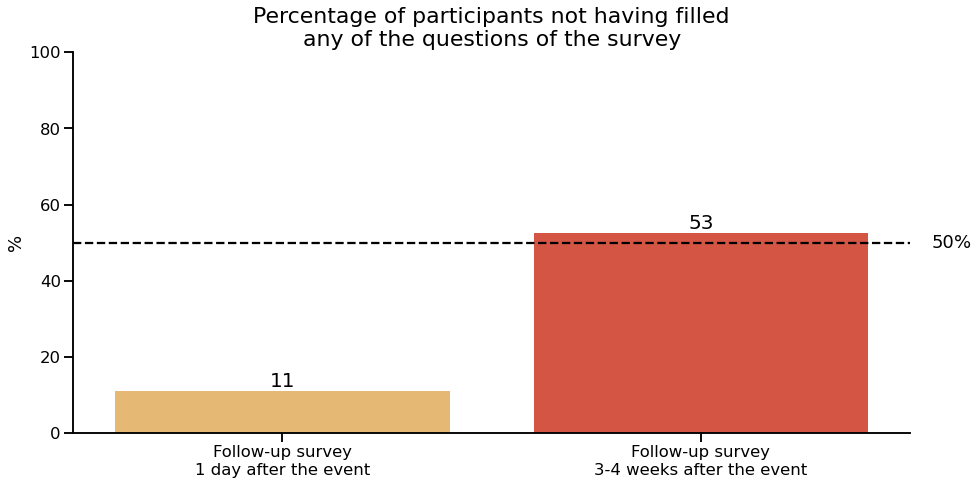

In [17]:
sns.set_context("talk") # Setting a default scale for the axis and labels
plt.figure(figsize = (15,7))
plt.title("Percentage of participants not having filled\nany of the questions of the survey", fontdict = {'fontsize': 22})
ax = sns.barplot(x = time_labels[2:], y = no_answer_ratio, saturation = 0.7, palette ="YlOrRd")
ax.bar_label(ax.containers[0], fmt = '%.0f', fontsize = 20) # Adding values over bars, shown as integers
plt.axhline(y = 50, ls = '--', c = 'Black')
ax.text(1.55, 50,'50%', verticalalignment = 'center', fontsize=18)
ax.set_ylim([0, 100])
ax.set_ylabel('%')

sns.despine() # removing the right and top frame lines around the figure
plt.show()

-> We see that **for the final part of the survey, a majority of students did not respond at all !**    

To see if some questions in particular were harder to respond than others, we have to compare them without taking in account in the missing values calculation the people not having responded at all. 

In [18]:
def get_missing_values_percentage_rescaled(dataframe):
    # Input : dataframe (n rows, m columns)
    # Output : a series (m values) whose indexes are the input dataframe column names 
    #          and the values are the percentage of missing values found in the column,
    #          rounded to 2 decimal places, 
    #          after removal in the input dataframe of the lines having only missing values
    clean_dataframe = dataframe[~dataframe.isnull().all(axis = 1)] # Taking away the lines with only NAN values
    print(f"Found {100-round(clean_dataframe.shape[0]/dataframe.shape[0]*100)}% of lines having only NA values, removed from the calculation of missing values percentage.")
    return clean_dataframe.isnull().sum().apply(lambda x : round(x/clean_dataframe.shape[0]*100, 2)) 

In [19]:
after_1d_missing_values_series_rescaled = get_missing_values_percentage_rescaled(df_after_1d)
after_3w_missing_values_series_rescaled = get_missing_values_percentage_rescaled(df_after_3w)

Found 11% of lines having only NA values, removed from the calculation of missing values percentage.
Found 53% of lines having only NA values, removed from the calculation of missing values percentage.


In [20]:
missing_values_series_rescaled_list = missing_values_series_list[:2] + [after_1d_missing_values_series_rescaled, after_3w_missing_values_series_rescaled]

In [21]:
missing_values_rescaled_summary = []
for i, df_part in enumerate(df_list):
    missing_values_mean_percentage = missing_values_series_rescaled_list[i].mean()
    missing_values_rescaled_summary.append(missing_values_mean_percentage)
missing_values_rescaled_summary = pd.Series(missing_values_rescaled_summary, index = time_labels)

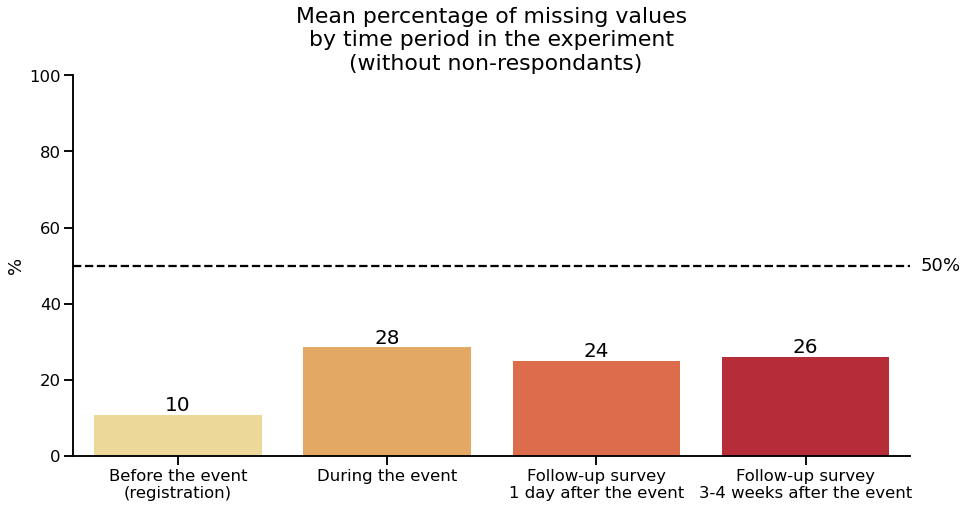

In [22]:
sns.set_context("talk") # Setting a default scale for the axis and labels
plt.figure(figsize = (15,7))
plt.title("Mean percentage of missing values\nby time period in the experiment\n (without non-respondants)", fontdict = {'fontsize': 22})
ax = sns.barplot(x = missing_values_rescaled_summary.index, y = missing_values_rescaled_summary.values, saturation = 0.7, palette ="YlOrRd")
ax.bar_label(ax.containers[0], fmt = '%d', fontsize = 20) # Adding values over bars, shown as integers
plt.axhline(y = 50, ls = '--', c = 'Black')
ax.text(3.55, 50,'50%', verticalalignment = 'center', fontsize=18)
ax.set_ylim([0, 100])
ax.set_ylabel('%')

sns.despine() # removing the right and top frame lines around the figure
plt.show()

-> We see now that, once we took away of each survey data the people not having responded at all, **the missing values rate is much more stable over time, which means that the respondants probably did not struggle more in answering the last survey than the others.** 

**It will hence be easier to compare the missing values rates for specific questions 'on the same scale' across all the survey data.**

In [23]:
missing_values_df_rescaled_list = []
for missing_values_part_series, time_label in zip(missing_values_series_rescaled_list, time_labels):
    missing_values_part_df = pd.DataFrame(missing_values_part_series.values, index = missing_values_part_series.index, columns = ['%_NAN'])
    missing_values_part_df['time_label'] = time_label
    missing_values_df_rescaled_list.append(missing_values_part_df)
missing_values_df_rescaled = pd.concat(missing_values_df_rescaled_list)

In [24]:
rescaled_missing_values_fig = go.Figure(
    data = go.Bar(
        x = [missing_values_df_rescaled['time_label'], missing_values_df_rescaled.index], 
        y = missing_values_df_rescaled['%_NAN']),
    layout = go.Layout(
        title = go.layout.Title(text = "Missing values percentage in the survey data <br>(without non-respondants)", x = 0.5),
        xaxis = go.layout.XAxis(title = 'data',  tickangle = -90, rangeslider = go.layout.xaxis.Rangeslider(visible = True)),
        yaxis = go.layout.YAxis(title = '%', range = [0, 100])
    )
)

rescaled_missing_values_fig.add_hline(y = missing_values_df_rescaled['%_NAN'].mean(), line_color = 'black', 
                              line_dash = 'dash', 
                              annotation_text = f"mean<br>({round(missing_values_df_rescaled['%_NAN'].mean())}%)", # plotly annotations are in html format
                              annotation_xanchor = 'left', 
                              annotation_x = 1.01, 
                              annotation_font_size = 14) #the last arguments are kwargs from the add_shape arguments and layout.Annotation properties 

rescaled_missing_values_fig.show()

**-> if we take away the temporal aspect of quantity of missing values, we see that some questions are much more oftenly skipped than others :**  

**Before the event :** 
- the information missing the most (78% !) is 'expnum', the expected number of matches the student will likely have during the event. As we notice also that there are more than 41% missing values for all attributes relative to how the student is perceived by others (attributes '5_1'), it seems the participants are not really keen on evaluating themselves amongst others on the 'market of love'...
    It doesn't mean although that they don't want to talk about themselves, because we see that the questions on how do the student measure up have a nearly maximum response rate !  
- the questions on the background of the particpants ('undergra', 'mn_sat', 'tuition' and 'income') are also very oftenly skipped (between 40% and 60%)

**During the event :**
- a majority of people don't have answered to the last questions concerning what they look for in the opposite sex (attributes '1_s') and how they measure up themselves (attributes '3_s'). It turns out that all these questions come halfway through the meeting. It is difficult at this point to interpret if the lack of answers was due to organization or to the relevance of the questions perceived by the students.

**1 day after the event :**  
- Many of the respondants (73%) have not answered the questions regarding the role played by the differents attributes of partners in the yes/no decisions during the event.
- We see that this time, students were more interested in answering about themselves (what they look for -attributes '1_2', and how they measure up -attributes '3_2') than in assuming about others (attributes '4_2', '2_2' and '5_2'). One thing that doesn't change since before the event is they still don't know or don't want to tell how they think others perceive them.

**3-4 weeks after matches :**
- Many of the respondants (60%) don't have answered to the question regarding how many of their matches they've been on a date with so far, and even more (83% !) didn't answer to the immediate following question 'If yes, how many ?' (maybe because this last question is quite hard to understand !)
- The majority of respondants still don't answer much to the questions regarding the role played by the differents attributes of partners in the yes/no decisions during the event (attributes '7_3') and how others perceive them (attributes '5_3'). 
- This time again, like in the 1-day-after survey, every respondant has answered to the questions regarding themselves (attributes '1_3' and '3_3') and where more hesitant when assuming about others (attributes '4_3' and '2_3'). 

### 2.4. Conclusion

After this analysis on missing values, we can assume that : 

1. There was a clear increase in missing values over time, explained more by a **progressive disinterest of the participants in the study** than by an increasing complexity of the questions (as the missing values rate once we took away the non-respondants is quite constant). The very high rate of non-respondants to the last survey can be explained by **the absence of incentive given to respond** (contrarily to the previous follow-up survey which had to be submitted in order for the participants to be sent their matches), in addition to **the time taken between the event and this last survey.**  

2. Once the temporal aspect set aside, we saw that **the respondants are more eager to answer to questions about their own personality or opinions than on others'.** 



